# 1. Loading modules

In [1]:
%matplotlib notebook
import time
import numpy as np
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.interpolate import *
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from matplotlib import colormaps
list(colormaps)
import pandas as pd
from pprint import pprint
import os, sys
#from time import sleep, monotonic
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import qcodes as qc
from qcodes import Parameter
from qcodes import initialise_or_create_database_at
from qcodes import load_or_create_experiment
from qcodes.dataset.plotting import plot_dataset, plot_by_id
from qcodes.utils.metadata import diff_param_values
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter

import pyppt as ppt

In [2]:
dirpath = os.getcwd()
# sample_name = dirpath.split('\\')[-2]
# wafer_name = dirpath.split('\\')[-3]
db_path = dirpath.rsplit('\\',0)[0]

In [3]:
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(db_path):
    for file in f:
        if '.db' in file:
            files.append(os.path.join(r, file))

for f in files:
    print(f)

D:\data\Kay\MoTe2_026_CrAu\MoTe2_026_CrAu_2023-12-27_01.db
D:\data\Kay\MoTe2_026_CrAu\MoTe2_026_CrAu_2023-12-27_01.db-shm
D:\data\Kay\MoTe2_026_CrAu\MoTe2_026_CrAu_2023-12-27_01.db-wal


In [4]:
db_path = os.path.join(db_path, 'MoTe2_026_CrAu_2023-12-27_01.db')
initialise_or_create_database_at(db_path)


# 2. Experiments List

In [5]:
qc.experiments()

[I vs V#IV_1k#1@D:\data\Kay\MoTe2_026_CrAu\MoTe2_026_CrAu_2023-12-27_01.db
 -------------------------------------------------------------------------
 1-results-1-appl_current,meas_voltage_K2-101,
 I vs V#IV_1k#2@D:\data\Kay\MoTe2_026_CrAu\MoTe2_026_CrAu_2023-12-27_01.db
 -------------------------------------------------------------------------
 2-results-1-appl_current,meas_voltage_K2-101,
 I vs V#IV_1k#3@D:\data\Kay\MoTe2_026_CrAu\MoTe2_026_CrAu_2023-12-27_01.db
 -------------------------------------------------------------------------
 3-results-1-appl_current,meas_voltage_K2-101,
 I vs V#IV_1k#4@D:\data\Kay\MoTe2_026_CrAu\MoTe2_026_CrAu_2023-12-27_01.db
 -------------------------------------------------------------------------
 4-results-1-appl_current,meas_voltage_K2-101,
 I vs V#IV_1k#5@D:\data\Kay\MoTe2_026_CrAu\MoTe2_026_CrAu_2023-12-27_01.db
 -------------------------------------------------------------------------
 5-results-1-appl_current,meas_voltage_K2-101,
 I vs V#IV_17_1

In [6]:
def get_R_from_IV(dataid):
    dataset = qc.load_by_id(dataid)

    voltage = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2'] #['meas_voltage_K1']['meas_voltage_K1']
    current = dataset.get_parameter_data()['meas_voltage_K2']['appl_current'] #['meas_voltage_K1']['appl_current']
    fit_values = np.polyfit(current,voltage,1)
    
    return fit_values[0]

# Analysis

## 1D

In [ ]:
#only one curve
dataset = qc.load_by_id(5)

# plot_dataset(dataset, fig_index=2)  # Use fig_index=2 to display Figure 3
plot_dataset(dataset)

Trying to mark a run completed that was already completed.


<IPython.core.display.Javascript object>


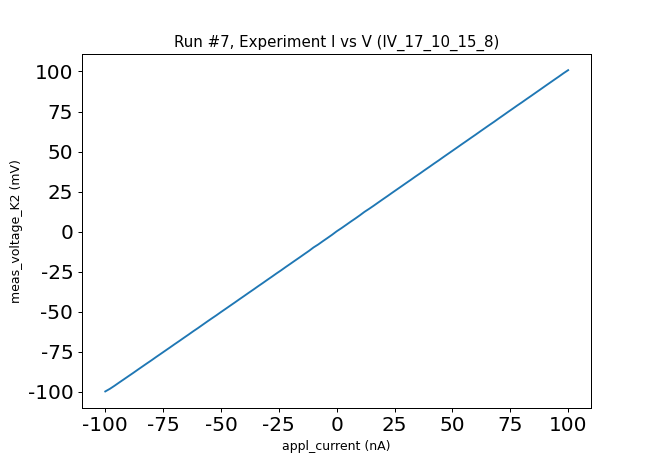

(array([-0.125, -0.1  , -0.075, -0.05 , -0.025,  0.   ,  0.025,  0.05 ,
         0.075,  0.1  ,  0.125]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

In [9]:
plot_by_id(7)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


# print(get_R_from_IV(dataid))
# print(get_R_from_IV_2(dataid))

In [7]:
runid=6
print(get_R_from_IV(runid))

-160770.9226354106


## diff

### PD

In [ ]:
#only one curve
dataset = qc.load_by_id(53)

# plot_dataset(dataset, fig_index=2)  # Use fig_index=2 to display Figure 3
plot_dataset(dataset)

In [ ]:
# Keithley1 = dataset.get_parameter_data()['meas_voltage_K1']['meas_voltage_K1']
Keithley2 = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']
# lockin_1_X = dataset.get_parameter_data()['meas_voltage_ac_L1']['meas_voltage_ac_L1']
# lockin_2_X = dataset.get_parameter_data()['meas_voltage_ac_L2']['meas_voltage_ac_L2']
# crymag_field = dataset.get_parameter_data()['meas_voltage_K1']['magnet_x_ramp'] ##correction in perpendiculr direction
# By_field =dataset.get_parameter_data()['meas_voltage_K1']['y_field'] ##correction in perpendiculr direction
#Bx_field =dataset.get_parameter_data()['meas_voltage_K2']['x_field'] ##correction in perpendiculr direction
Power_dependence = dataset.get_parameter_data()['meas_voltage_K2']['SGS_power']
#Power_dependence =dataset.get_
I = dataset.get_parameter_data()['meas_voltage_K2']['appl_current']
# Iac = dataset.snapshot['station']['parameters']['appl_current_AC_L1']['raw_value']

In [ ]:
# s=len(Vg)
s=len(I)
#print(s)
N=1
for i in range(s):
#     if By_field[i]!=By_field[i+1]:
    if Power_dependence[i]!=Power_dependence[i+1]:
#     if Vg[i]!=Vg[i+1]:
        break 
    else:
        N=N+1
        print('size of the gate array',N, end='\r')

NI=N
NB=s//N
# NVg=s//N
print('size of the field array', NB)
# print('size of the gate array', NVg)
print('size of the current', NI)

In [ ]:
#DC Bias vs. field 
R_DC1 = Keithley2/(I[2]-I[1])
R_DC1 = R_DC1.reshape(NB,NI)
# R_DC1 = R_DC1.reshape(NVg,NI)
R_DC1_d = np.diff(R_DC1, axis = 1)
# R_DC2 = Keithley2/(I[2]-I[1])A
# R_DC1_d = R_DC1_d.reshape(NB,NI)
# R_DC2 = R_DC2.reshape(NVg,NI)
# R_DC2 = np.diff(R_DC2, axis = 1)
# R_DC1=R_DC1.transpose()
I=I.reshape(NB,NI)
# I=I.reshape(NVg,NI)
# I=I.transpose()
# By_field =By_field.reshape(NB,NI)
#Bx_field =Bx_field.reshape(NB,NI)
Power_dependence =Power_dependence.reshape(NB,NI)
Keithley2 = Keithley2.reshape(NB,NI)
# Vg = Vg.reshape(NVg,NI)
# crymag_field=crymag_field.transpose()

#### 對I作圖

In [ ]:
fig, (ax0) = plt.subplots(ncols=1, figsize=(8,6))
fig.subplots_adjust(hspace=55)
cmap = plt.get_cmap('hot')

Arange=0
Brange=600
im = ax0.pcolormesh(Power_dependence[Arange:Brange,0:NI-1], I[Arange:Brange,0:NI-1]/1e-6, R_DC1_d[Arange:Brange,0:NI-1], cmap = cmap, vmax=80,vmin=0)
fig.colorbar(im, ax=ax0)
# ax0.set_title('id=run140')
ax0.set(xlabel='Power (dBm)', ylabel='I ($\mu$A)') 


fig.tight_layout()
#plt.grid()
plt.show()
# ppt.add_figure('Center')

#### 對V作圖

In [ ]:
fig, (ax0) = plt.subplots(ncols=1, figsize=(8,7))
fig.subplots_adjust(hspace=55)
cmap = plt.get_cmap('hot')

Arange=0
Brange=800
im = ax0.pcolormesh(Power_dependence[Arange:Brange,0:NI-1], Keithley2[Arange:Brange,0:NI-1]/1e-6, R_DC1_d[Arange:Brange,0:NI-1], cmap = cmap, vmax=80,vmin=0)
fig.colorbar(im, ax=ax0)
# ax0.set_title('id=run140')
ax0.set(xlabel='Power (dBm)', ylabel='V ($\mu$V)') 


fig.tight_layout()
#plt.grid()
plt.show()
# ppt.add_figure('Center')

### Bx

In [ ]:
#only one curve
dataset = qc.load_by_id(66)

# plot_dataset(dataset, fig_index=2)  # Use fig_index=2 to display Figure 3
plot_dataset(dataset)

In [ ]:
# Keithley1 = dataset.get_parameter_data()['meas_voltage_K1']['meas_voltage_K1']
Keithley2 = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']
# lockin_1_X = dataset.get_parameter_data()['meas_voltage_ac_L1']['meas_voltage_ac_L1']
# lockin_2_X = dataset.get_parameter_data()['meas_voltage_ac_L2']['meas_voltage_ac_L2']
# crymag_field = dataset.get_parameter_data()['meas_voltage_K1']['magnet_x_ramp'] ##correction in perpendiculr direction
#By_field =dataset.get_parameter_data()['meas_voltage_K2']['y_field'] ##correction in perpendiculr direction
Bx_field =dataset.get_parameter_data()['meas_voltage_K2']['x_field'] ##correction in perpendiculr direction
#Power_dependence = dataset.get_parameter_data()['meas_voltage_K2']['SGS_power']
#Power_dependence =dataset.get_
I = dataset.get_parameter_data()['meas_voltage_K2']['appl_current']
# Iac = dataset.snapshot['station']['parameters']['appl_current_AC_L1']['raw_value']

In [ ]:
# s=len(Vg)
s=len(I)
#print(s)
N=1
for i in range(s):
#     if By_field[i]!=By_field[i+1]:
    if Bx_field[i]!=Bx_field[i+1]:
#     if Vg[i]!=Vg[i+1]:
        break 
    else:
        N=N+1
        print('size of the gate array',N, end='\r')

NI=N
NB=s//N
# NVg=s//N
print('size of the field array', NB)
# print('size of the gate array', NVg)
print('size of the current', NI)

In [ ]:
#DC Bias vs. field 
R_DC1 = Keithley2/(I[2]-I[1])
R_DC1 = R_DC1.reshape(NB,NI)
# R_DC1 = R_DC1.reshape(NVg,NI)
R_DC1_d = np.diff(R_DC1, axis = 1)
# R_DC2 = Keithley2/(I[2]-I[1])A
# R_DC1_d = R_DC1_d.reshape(NB,NI)
# R_DC2 = R_DC2.reshape(NVg,NI)
# R_DC2 = np.diff(R_DC2, axis = 1)
# R_DC1=R_DC1.transpose()
I=I.reshape(NB,NI)
# I=I.reshape(NVg,NI)
# I=I.transpose()
# By_field =By_field.reshape(NB,NI)
Bx_field =Bx_field.reshape(NB,NI)
#Power_dependence =Power_dependence.reshape(NB,NI)
Keithley2 = Keithley2.reshape(NB,NI)
# Vg = Vg.reshape(NVg,NI)
# crymag_field=crymag_field.transpose()

In [ ]:
fig, (ax0) = plt.subplots(ncols=1, figsize=(8,6))
fig.subplots_adjust(hspace=55)
cmap = plt.get_cmap('hot')

Arange=0
Brange=8000

im = ax0.pcolormesh(Bx_field[Arange:Brange,0:NI-1]/1e-3+17.24, I[Arange:Brange,0:NI-1]/1e-6, R_DC1_d[Arange:Brange,0:NI-1], cmap = cmap, vmax=110,vmin=0)
fig.colorbar(im, ax=ax0)
# ax0.set_title('id=run140')
ax0.set(xlabel='By (mT)', ylabel='I (uA)') 


fig.tight_layout()
#plt.grid()
plt.show()
# ppt.add_figure('Center')

### By

In [ ]:
#only one curve
dataset = qc.load_by_id(19)

# plot_dataset(dataset, fig_index=2)  # Use fig_index=2 to display Figure 3
plot_dataset(dataset)

In [ ]:
# Keithley1 = dataset.get_parameter_data()['meas_voltage_K1']['meas_voltage_K1']
Keithley2 = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']
# lockin_1_X = dataset.get_parameter_data()['meas_voltage_ac_L1']['meas_voltage_ac_L1']
# lockin_2_X = dataset.get_parameter_data()['meas_voltage_ac_L2']['meas_voltage_ac_L2']
# crymag_field = dataset.get_parameter_data()['meas_voltage_K1']['magnet_x_ramp'] ##correction in perpendiculr direction
By_field =dataset.get_parameter_data()['meas_voltage_K2']['y_field'] ##correction in perpendiculr direction
#Bx_field =dataset.get_parameter_data()['meas_voltage_K2']['x_field'] ##correction in perpendiculr direction
#Power_dependence = dataset.get_parameter_data()['meas_voltage_K2']['SGS_power']
#Power_dependence =dataset.get_
I = dataset.get_parameter_data()['meas_voltage_K2']['appl_current']
# Iac = dataset.snapshot['station']['parameters']['appl_current_AC_L1']['raw_value']

In [ ]:
# s=len(Vg)
s=len(I)
#print(s)
N=1
for i in range(s):
#     if By_field[i]!=By_field[i+1]:
    if By_field[i]!=By_field[i+1]:
#     if Vg[i]!=Vg[i+1]:
        break 
    else:
        N=N+1
        print('size of the gate array',N, end='\r')

NI=N
NB=s//N
# NVg=s//N
print('size of the field array', NB)
# print('size of the gate array', NVg)
print('size of the current', NI)

In [ ]:
#DC Bias vs. field 
R_DC1 = Keithley2/(I[2]-I[1])
R_DC1 = R_DC1.reshape(NB,NI)
# R_DC1 = R_DC1.reshape(NVg,NI)
R_DC1_d = np.diff(R_DC1, axis = 1)
# R_DC2 = Keithley2/(I[2]-I[1])A
# R_DC1_d = R_DC1_d.reshape(NB,NI)
# R_DC2 = R_DC2.reshape(NVg,NI)
# R_DC2 = np.diff(R_DC2, axis = 1)
# R_DC1=R_DC1.transpose()
I=I.reshape(NB,NI)
# I=I.reshape(NVg,NI)
# I=I.transpose()
By_field =By_field.reshape(NB,NI)
#Bx_field =Bx_field.reshape(NB,NI)
#Power_dependence =Power_dependence.reshape(NB,NI)
Keithley2 = Keithley2.reshape(NB,NI)
# Vg = Vg.reshape(NVg,NI)
# crymag_field=crymag_field.transpose()

In [ ]:
fig, (ax0) = plt.subplots(ncols=1, figsize=(9,7))
fig.subplots_adjust(hspace=55)
cmap = plt.get_cmap('hot')

Arange=0
Brange=2000
im = ax0.pcolormesh(By_field[Arange:Brange,0:NI-1]/1e-3+0.065, I[Arange:Brange,0:NI-1]/1e-6, R_DC1_d[Arange:Brange,0:NI-1], cmap = cmap, vmax=80,vmin=0)
fig.colorbar(im, ax=ax0)
# ax0.set_title('id=run140')
ax0.set(xlabel='Bx (mT)', ylabel='I (uA)') 


fig.tight_layout()
#plt.grid()
plt.show()
# ppt.add_figure('Center')

## Change colormap

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# 假設 qc.load_by_id(73) 返回一個 DataSet 對象
dataset = qc.load_by_id(92)


cmap = plt.get_cmap('bwr')


# Plot the dataset with the specified colormap
axs, cbs = plot_dataset(dataset, cmap=cmap)

# 顯示圖形
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# 假设 qc.load_by_id(73) 返回一个 DataSet 对象
dataset = qc.load_by_id(92)

# 创建自定义的颜色映射
colors = [(0, 'yellow'),(0.15, 'red'),(0.5, 'black'),(0.85, 'red'),(1, 'yellow')]  # 中间段为紫色，更宽
cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

# Plot the dataset with the specified colormap
axs, cbs = plot_dataset(dataset, cmap=cmap)

# 显示图形
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# 假设 qc.load_by_id(73) 返回一个 DataSet 对象
dataset = qc.load_by_id(23)

# 创建自定义的颜色映射
colors = [(0, 'yellow'),(0.15, 'red'),(0.4, 'black'),(0.5, 'black'),(0.6, 'black'),(0.85, 'red'),(1, 'yellow')]  # 中间段为紫色，更宽
cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

# Plot the dataset with the specified colormap
axs, cbs = plot_dataset(dataset, cmap=cmap)

# 显示图形
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# 假设 qc.load_by_id(73) 返回一个 DataSet 对象
dataset = qc.load_by_id(237)

# 创建自定义的颜色映射
colors = [(0, 'black'),(0.5, 'pink'),(1, 'black')]  # 中间段为紫色，更宽
cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

# Plot the dataset with the specified colormap
axs, cbs = plot_dataset(dataset, cmap=cmap)

# 显示图形
plt.show()

##  疊圖 

In [ ]:
dataset = qc.load_by_id(167)
X1 =  dataset.get_parameter_data()['meas_voltage_K2']['appl_current'] 
Y1 =  dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']
#Keithley1_73 = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']
#lockin_1_X_73 = dataset.get_parameter_data()['meas_voltage_Lockin1']['meas_voltage_Lockin1']
#I_73 = dataset.get_parameter_data()['meas_voltage_K2']['appl_current']
#Iac_73 = dataset.snapshot['station']['parameters']['appl_current_AC']['raw_value']

#dataset = qc.load_by_id(165)
#X2 =  dataset.get_parameter_data()['meas_voltage_K2']['appl_current'] 
#Y2 =  dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']

#dataset = qc.load_by_id(161)
#X3 =  dataset.get_parameter_data()['meas_voltage_K2']['appl_current'] 
#Y3 =  dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']

#dataset = qc.load_by_id(163)
#X4 =  dataset.get_parameter_data()['meas_voltage_K2']['appl_current'] 
#Y4 =  dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']

#dataset = qc.load_by_id(148)
#X5 =  dataset.get_parameter_data()['meas_voltage_K2']['appl_current'] 
#Y5 =  dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']


#dataset = qc.load_by_id(149)
#X6 =  dataset.get_parameter_data()['meas_voltage_K2']['appl_current'] 
#Y6 =  dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']


#dataset = qc.load_by_id(150)
#X7 =  dataset.get_parameter_data()['meas_voltage_K2']['appl_current'] 
#Y7 =  dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']


#dataset = qc.load_by_id(151)
#X8 =  dataset.get_parameter_data()['meas_voltage_K2']['appl_current'] 
#Y8 =  dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']




# X3_data = X3['appl_current']['appl_current']
# Y3_data = Y3['meas_voltage_K2']['meas_voltage_K2']

##### a) 空白背景

In [ ]:
plt.figure(figsize=(5, 3))
N=50
# plt.subplot(131)
# plt.plot(I[N,:]/1e-6, Keithley[N,:]/1e-3)
#plt.plot(5.5381*X2/1e-5,(Y2/1e-6), label='5.5381 GHz')
# plt.plot(Keithley1_73/1e-6,I_73/1e-9, label='12.43 GHz')
plt.plot(4.303*X1/1e-5,Y1/1e-6, label='4.303 GHz')
#plt.plot(Y2/1e-6,X2/1e-9, label='2.63 GHz')
#plt.plot(5.3986*X3/1e-5,Y3/1e-6, label='5.3986 GHz')
# plt.plot(Y3/1e-6, X3/1e-9, label='4.82 GHz')
#plt.plot(5.876*X4/1e-5,Y4/1e-6, label='5.876 GHz')
#plt.plot(Y2/1e-6,X2/1e-9, label='2.63 GHz')
#plt.plot(6.155*X3/1e-5,Y3/1e-6, label='6.155 GHz')
#plt.plot(Y2/1e-6,X2/1e-9, label='2.63 GHz')
#plt.plot(7.4105*X6/1e-5,Y4/1e-6, label='7.410 GHz')
#plt.plot(Y2/1e-6,X2/1e-9, label='2.63 GHz')
#plt.plot(7.769*X4/1e-5,Y4/1e-6, label='7.769 GHz')
#plt.plot(Y2/1e-6,X2/1e-9, label='2.63 GHz')
#plt.plot(8.167*X8/1e-5,Y4/1e-6, label='8.167 GHz')
#plt.plot(Y2/1e-6,X2/1e-9, label='2.63 GHz')


plt.xlabel('I ($\mu$A)')
plt.ylabel('V ($\mu$V)')

plt.legend()
plt.suptitle('Power 0dB, V$_g$ =0 V')
# legend()
# DCoff=np.mean(Keithley[N,0:30])
#plt.plot(t,x[t], "o")
# plt.plot(-y_Smooth)
# plt.plot(dips, -y_Smooth[dips], "x")
# plt.add_figure('topleft')
# print(DCoff)

##### b) 格線背景

In [ ]:
plt.figure(figsize=(5, 3))
N=50
# plt.subplot(131)
# plt.plot(I[N,:]/1e-6, Keithley[N,:]/1e-3)
plt.plot(5.5381*X2/1e-5,(Y2/6e-6), label='5.5381 GHz')
# plt.plot(Keithley1_73/1e-6,I_73/1e-9, label='12.43 GHz')
plt.plot(4.303*X1/1e-5,Y1/6e-6, label='4.303 GHz')
#plt.plot(Y2/1e-6,X2/1e-9, label='2.63 GHz')
#plt.plot(5.3986*X3/1e-5,Y3/1e-6, label='5.3986 GHz')
# plt.plot(Y3/1e-6, X3/1e-9, label='4.82 GHz')
#plt.plot(5.876*X4/1e-5,Y4/1e-6, label='5.876 GHz')
#plt.plot(Y2/1e-6,X2/1e-9, label='2.63 GHz')
plt.plot(6.155*X3/1e-5,Y3/6e-6, label='6.155 GHz')
#plt.plot(Y2/1e-6,X2/1e-9, label='2.63 GHz')
#plt.plot(7.4105*X6/1e-5,Y4/1e-6, label='7.410 GHz')
#plt.plot(Y2/1e-6,X2/1e-9, label='2.63 GHz')
plt.plot(7.769*X4/1e-5,Y4/6e-6, label='7.769 GHz')
#plt.plot(Y2/1e-6,X2/1e-9, label='2.63 GHz')
#plt.plot(8.167*X8/1e-5,Y4/1e-6, label='8.167 GHz')
#plt.plot(Y2/1e-6,X2/1e-9, label='2.63 GHz')

# 添加网格线
plt.grid(True)

plt.xlabel('I ($\mu$A)')
plt.ylabel('V ($\\frac{\hbar\\omega}{2e}$)')


plt.legend()
#plt.suptitle('Power 0 dB, V$_g$ = 0 V')
plt.show()

# 4. Field vs IV

In [ ]:
dataset = qc.load_by_id(73)
#plot_dataset(dataset)
#plt.show()

# Test Code

In [ ]:
dataset = qc.load_by_id(237)

# 对电流-电压曲线进行微分
voltage= dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2'] #['meas_voltage_K1']['meas_voltage_K1']
current = dataset.get_parameter_data()['meas_voltage_K2']['appl_current'] #['meas_voltage_K1']['appl_current']

differential = np.diff(voltage) / np.diff(current)

# 绘制微分后的数据
plt.plot(current[:-1], differential)
plt.xlabel('Power (dB)')
plt.ylabel('dV/dI')
plt.title('dV/dI vs ')
plt.show()

In [ ]:
# Get the colormap you want to use
cmap = plt.get_cmap('bwr')

# Plot the dataset with the specified colormap
axs, cbs = plot_dataset(dataset, cmap=cmap)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一个示例图像
data = np.random.random((10, 10))

# 绘制图像
img = plt.imshow(data, cmap='hot', vmin=0, vmax=1)

# 创建colorbar
cbar = plt.colorbar(img)

# 设置colorbar的范围
cbar.set_ticks([0.2, 0.5, 0.8])  # 设置刻度位置
cbar.set_ticklabels(['Low', 'Medium', 'High'])  # 设置刻度标签

# 显示图像
plt.show()



In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# 创建一个示例图像
data = np.random.random((10, 10))

# 创建自定义的颜色映射
colors = [(0, 'blue'), (0.5, 'black'), (1, 'red')]  # 中间段为黑色
cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

# 绘制图像
img = plt.imshow(data, cmap=cmap, vmin=0, vmax=1)

# 创建colorbar
cbar = plt.colorbar(img)

# 显示图像
plt.show()



In [ ]:
import matplotlib.pyplot as plt

# 使用Viridis颜色映射
viridis_cmap = plt.get_cmap('viridis')

# 获取Viridis颜色映射中绿色的RGB值
green_color = viridis_cmap(0.5)[:3]

# 打印结果
print("Viridis颜色映射中绿色的RGB值:", green_color)


In [ ]:
dataset = qc.load_by_id(146)
X1 =  dataset.get_parameter_data()['meas_voltage_K2']['appl_current'] 
Y1 =  dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']


cmap = plt.get_cmap('bwr')

# Plot the dataset with the specified colormap
axs, cbs = plot_dataset(dataset, cmap=cmap)

plt.xlabel('I ($\mu$A)')
plt.ylabel('V ($\mu$V)')


plt.suptitle('Power 25dB, V$_g$ =0 V')

In [ ]:
SGS.off()
SGS.power(10)
SGS.frequency(2.92047e9)
SGS.on()
keithley_2.averaging_count(5)
keithley_2.averaging_enabled(True)
keithley_24.output(1)

magnet_x.field(15e-3)
sleep(5)
appl_current(-1e-6)
#appl_TG(-30)
sleep(2)

# station.snapshot(update=True);
exp = qc.new_experiment('IV vs power dependence', sample_name='IV vs PD_10_15mT')

#do1d(param_set, start, stop, num_points, delay, *param_meas)

dataid = do2d(SGS.power,-15, 20, 101, 1, appl_current,-1e-6 ,1e-6, 101, 0.05, meas_voltage_K2)
# dataid = do1d(appl_current, 6e-6 , -6e-6, 251, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()

SGS.off()
appl_current(0)
keithley_24.output()
plot_by_id(dataid)

# print(get_R_from_IV(dataid))
print(get_R_from_IV_2(dataid))

In [ ]:
SGS.off()
SGS.power(10)
SGS.frequency(2.92047e9)
SGS.on()
keithley_2.averaging_count(5)
keithley_2.averaging_enabled(True)
keithley_24.output(1)

magnet_x.field(15e-3)
sleep(5)
appl_current(-1e-6)
#appl_TG(-30)
sleep(2)

# station.snapshot(update=True);
exp = qc.new_experiment('IV vs power dependence', sample_name='IV vs PD_10_15mT')

#do1d(param_set, start, stop, num_points, delay, *param_meas)

dataid = do2d(SGS.power,-15, 20, 101, 1, appl_current,-1e-6 ,1e-6, 101, 0.05, meas_voltage_K2)
# dataid = do1d(appl_current, 6e-6 , -6e-6, 251, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()

SGS.off()
appl_current(0)
keithley_24.output()
plot_by_id(dataid)

# print(get_R_from_IV(dataid))
print(get_R_from_IV_2(dataid))

In [ ]:
import matplotlib.pyplot as plt

# 提取数据，这里假设 dataid 是某个数据集的标识符
voltage_data = get_data_from_id(360, 'meas_voltage_K2')  # 请替换 'meas_voltage_K2' 为你的实际数据列名
power_data = get_data_from_id(360, 'SGS_power')  # 请替换 'SGS_power' 为你的实际数据列名

# 绘制 Voltage 对 Power 曲线
plt.plot(power_data, voltage_data, marker='o', linestyle='-')
plt.xlabel('Power (units)')
plt.ylabel('Voltage (units)')
plt.title('Voltage vs Power Dependence')

# 显示图表
plt.show()


In [ ]:
V = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']
I = dataset.get_parameter_data()['meas_voltage_K2']['appl_current']
R = np.diff(V) / np.diff(I)
P = dataset.get_parameter_data()['meas_voltage_K2']['SGS_power']
# B = dataset.get_parameter_data()['meas_voltage_K2']['x_field']
V = pd.DataFrame(V, columns=['Voltage_K2'])
I = pd.DataFrame(I, columns=['Current'])
R = pd.DataFrame(R, columns=['Risistance'])
P = pd.DataFrame(P, columns=['Power'])
# B = pd.DataFrame(B, columns=['B Field'])
R_append = pd.concat([R, pd.DataFrame([None])], ignore_index=True).iloc[:, :-1]
R_array = np.transpose(R_append.values.reshape(701,101))
print(len(V))
print(len(I))
print(len(R))
print(len(P))
print(len(R_array))

In [ ]:
# s = len(Vg)
s = len(I)
# print(s)
N = 1
for i in range(s - 1):
    if Power_dependence[i] != Power_dependence[i + 1]:
        break
    else:
        N = N + 1
        print('size of the gate array', N, end='\r')

NI = N
NB = s // N
# NVg = s // N
print('size of the field array', NB)
# print('size of the gate array', NVg)
print('size of the current', NI)

# 提取数据列
voltage_data = Vg[:N]  # 假设 Vg 是 Voltage 的数据列，如果不是，请替换为正确的列名
power_data = Power_dependence[:N]  # 假设 Power_dependence 是 Power 的数据列，如果不是，请替换为正确的列名

# 绘制 Voltage 对 Power 曲线
plt.plot(power_data, voltage_data, marker='o', linestyle='-')
plt.xlabel('Power (units)')
plt.ylabel('Voltage (units)')
plt.title('Voltage vs Power Dependence')

# 显示图表
plt.show()
